In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

sns.set_theme()

In [2]:
aapl = yf.download('AAPL', start = '2020-01-01', end = '2025-05-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

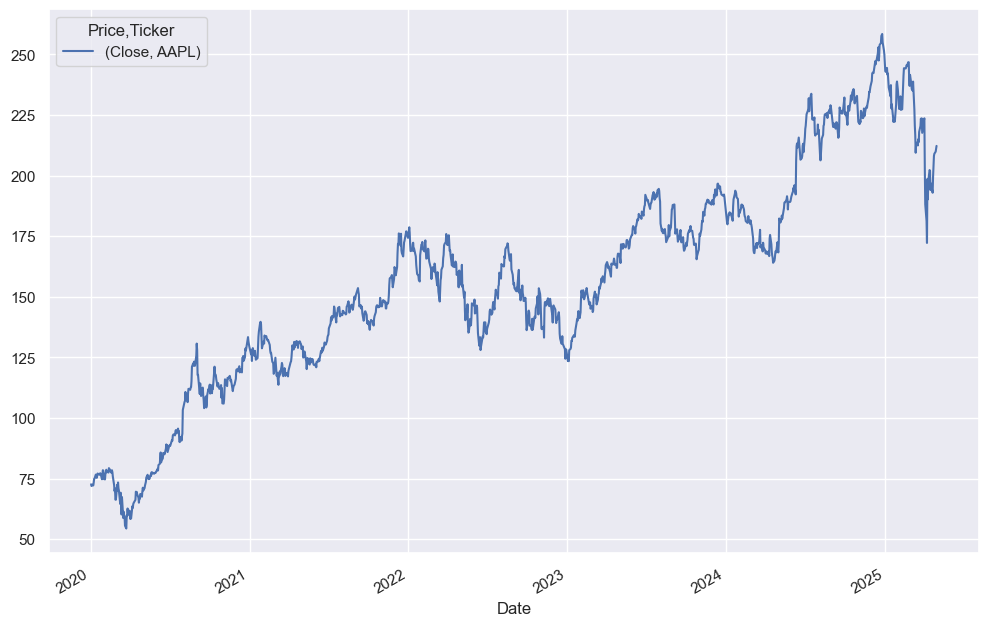

In [3]:
close_values = aapl[['Close']]
close_values.plot(kind = 'line', figsize=(12,8))

In [14]:
X_train, X_test = train_test_split(close_values, shuffle= False, test_size=0.2)

In [16]:
X_aux = X_train.copy()

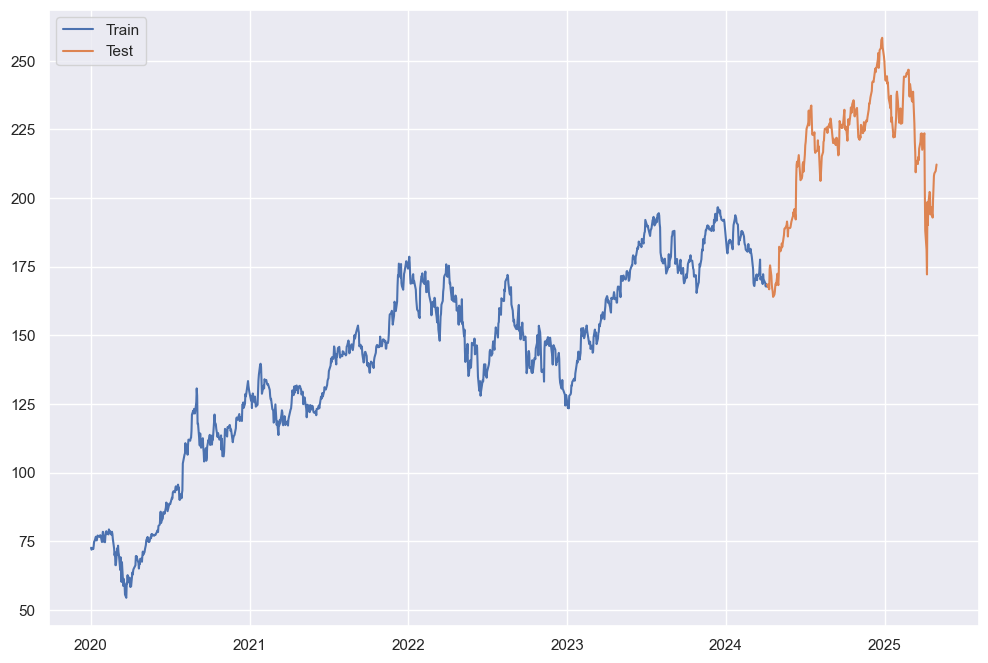

In [5]:
plt.figure(figsize=(12, 8))
plt.plot(X_train.index, X_train.values, label = "Train")
plt.plot(X_test.index, X_test.values, label = "Test")
plt.legend()


In [19]:
def split_serie(data):
    for lag in [1, 2, 3]:
        data[f"lag_{lag}"] = data['Close'].shift(lag)
        data[f"dif_{lag}"] = data['Close'].diff(lag)

    data.dropna(inplace = True)

    X = data.drop("Close", axis = 1).values
    y = data['Close'].values

    return X, y


In [ ]:
X, y = split_serie(X_train)

In [8]:
tscv = TimeSeriesSplit(n_splits = 5)
svr = SVR(kernel = 'rbf')

In [9]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 1],
    "epsilon": [0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_search.fit(X, y)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
             scoring='neg_mean_squared_error')

In [10]:
best_svr = grid_search.best_estimator_

best_svr.fit(X, y)

y_pred = best_svr.predict(X)
mse = mean_squared_error(y, y_pred)
r2  = r2_score(y, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}")

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test MSE: 0.0043
Test R²:  1.0000


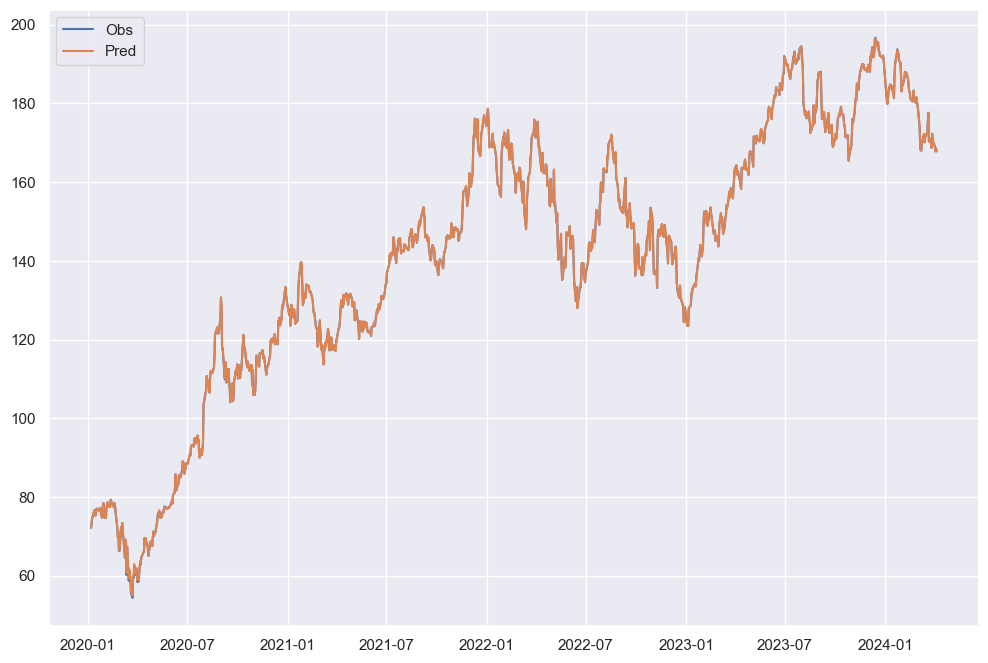

In [11]:
dates_train = X_train.index
plt.figure(figsize=(12, 8))
plt.plot(dates_train, y, label = 'Obs')
plt.plot(dates_train, y_pred, label = 'Pred')
plt.legend()

In [18]:
index_test = X_test.index